# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
dataset_path = '/kaggle/input/sncb-remote-diagnostics-in-fleet-maintenance/ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path, delimiter=';')

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17679273 entries, 0 to 17679272
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   mapped_veh_id       float64
 2   timestamps_UTC      object 
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 2.0+ GB
None
   Unnamed: 0  mapped_veh_id       timestamps_UTC        lat       lon  \
0           0          181.0  2023-08-01 03:44:12  50.769818  3.872114   
1           1          143.0  2023-08-01 06:36:29  51.039993  3.693429   
2           2          183.0  2023

# Remove Column `Unnamed: 0`

In [3]:
data.drop(['Unnamed: 0'], axis=1, inplace = True)
data.shape

(17679273, 14)

# Detect Missing Value

In [4]:
# Checking for missing values in each column
missing_values = data.isnull().sum()
missing_values

mapped_veh_id             0
timestamps_UTC            0
lat                       0
lon                       0
RS_E_InAirTemp_PC1        0
RS_E_InAirTemp_PC2    12726
RS_E_OilPress_PC1         0
RS_E_OilPress_PC2     12726
RS_E_RPM_PC1              0
RS_E_RPM_PC2          12726
RS_E_WatTemp_PC1          0
RS_E_WatTemp_PC2      12726
RS_T_OilTemp_PC1          0
RS_T_OilTemp_PC2      12726
dtype: int64

Find a lot of missing values, and the count of them are the same, so let's try to diagnose whether it is caused by systematic problem of senser from PC2

In [5]:
# Load a subset of the data for analysis, we are focusing on one column with missing values for demonstration
subset_data = pd.read_csv(dataset_path, delimiter = ';', usecols=['timestamps_UTC', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2'])

# Convert timestamps to datetime objects for easier analysis
subset_data['timestamps_UTC'] = pd.to_datetime(subset_data['timestamps_UTC'])

# Sort the data based on the timestamp
subset_data.sort_values('timestamps_UTC', inplace=True)

# Create a boolean series to indicate rows with missing values
missing_value_series = subset_data['RS_E_InAirTemp_PC2'].isnull()

# Print Missing Values
missing_value_series

11759521    False
14409419    False
13286611    False
17234666    False
5221806     False
            ...  
16724009    False
995273      False
14298087    False
15979243    False
10041108    False
Name: RS_E_InAirTemp_PC2, Length: 17679273, dtype: bool

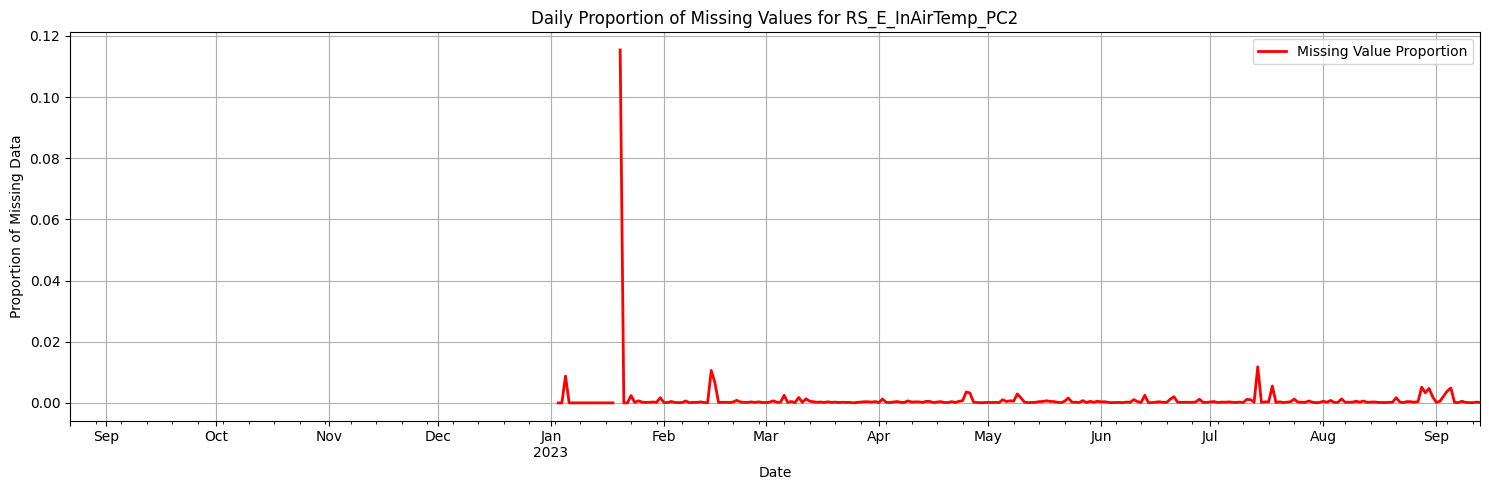

In [6]:
# Resampling the data to get daily missing data proportion
daily_missing_data = subset_data.set_index('timestamps_UTC').resample('D')['RS_E_InAirTemp_PC2'].apply(lambda x: x.isnull().mean())

# Plotting the line plot
plt.figure(figsize=(15,5))
daily_missing_data.plot(kind='line', color='red', label='Missing Value Proportion', lw=2)
plt.xlabel('Date')
plt.ylabel('Proportion of Missing Data')
plt.title('Daily Proportion of Missing Values for RS_E_InAirTemp_PC2')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

In [7]:
# Create a boolean series to indicate rows with missing values
missing_value_series_2 = subset_data['RS_E_OilPress_PC2'].isnull()

# Print Missing Values
missing_value_series_2

11759521    False
14409419    False
13286611    False
17234666    False
5221806     False
            ...  
16724009    False
995273      False
14298087    False
15979243    False
10041108    False
Name: RS_E_OilPress_PC2, Length: 17679273, dtype: bool

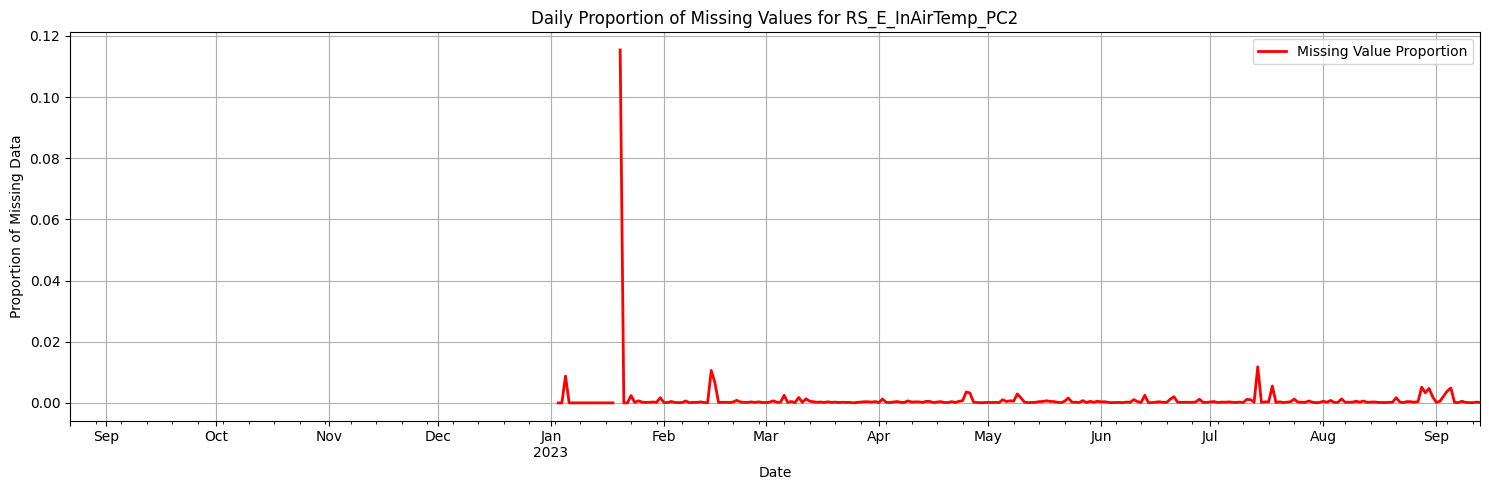

In [8]:
# Resampling the data to get daily missing data proportion
daily_missing_data = subset_data.set_index('timestamps_UTC').resample('D')['RS_E_OilPress_PC2'].apply(lambda x: x.isnull().mean())

# Plotting the line plot
plt.figure(figsize=(15,5))
daily_missing_data.plot(kind='line', color='red', label='Missing Value Proportion', lw=2)
plt.xlabel('Date')
plt.ylabel('Proportion of Missing Data')
plt.title('Daily Proportion of Missing Values for RS_E_InAirTemp_PC2')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

The two graph shows that the distribution of all missing value are the same, so let's remove the missing values

In [9]:
# Size of the dataset before removing missing values
original_size = data.shape

# Removing rows with missing values in any of the specified columns
columns_with_missing_values = [
    'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 
    'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2'
]

# Drop the rows contain the missing value
data = data.dropna(subset=columns_with_missing_values)

# Size of the dataset after removing missing values
data_size = data.shape

original_size, data_size

((17679273, 14), (17666547, 14))

# Remove Duplicate Rows

In [10]:
print(data.shape)

(17666547, 14)


In [11]:
data.drop_duplicates(inplace=True)

In [12]:
print(data.shape)

(17666547, 14)


no duplicate was found, move on

# Remove Value 0 from all columns

this code not worked because it will remove the tempure higher than usual (the information we need), bue do not treat tempurature 0 as outlier

In [13]:
# # Make use of IQR Methodology
# Q1 = data['RS_E_InAirTemp_PC1'].quantile(0.25)
# Q3 = data['RS_E_InAirTemp_PC1'].quantile(0.75)

# # Calculate IQR
# IQR = Q3 - Q1

# # Define Outlier Boundary
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Define Outliers
# outliers = data[(data['RS_E_InAirTemp_PC1'] < lower_bound) | (data['RS_E_InAirTemp_PC1'] > upper_bound)]

# outliers['RS_E_InAirTemp_PC1']

In [14]:
# list of columns should not contain 0 value
columns_need_check = ['mapped_veh_id', 'timestamps_UTC', 'lat', 'lon', 'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1',
       'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2']

# Remove all the rows where columns value contains 0
data = data[(data[columns_need_check] != 0).all(axis=1)]

data.shape

(16302714, 14)

# Convert the 'timestamps_UTC' column to datetime

In [15]:
# Convert the 'timestamps_UTC' column to datetime format and coerce errors
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'], errors='coerce')

# Verify the datatype of 'timestamps_UTC' after conversion
print(data['timestamps_UTC'].dtype)

# Extract date and time attributes for visualization
data['date'] = data['timestamps_UTC'].dt.date
data['time'] = data['timestamps_UTC'].dt.time
data['hour'] = data['timestamps_UTC'].dt.hour
data['day'] = data['timestamps_UTC'].dt.day
data['dayofweek'] = data['timestamps_UTC'].dt.dayofweek
data['weekday'] = data['timestamps_UTC'].dt.strftime('%A')

# Verify that the new columns have been created
print(data[['date', 'time', 'hour', 'day', 'dayofweek', 'weekday']].head())

# Drop the 'timestamps_UTC' column if it's no longer needed
data.drop(['timestamps_UTC'], axis=1, inplace=True)

# Verify the shape of the data
print(data.shape)


datetime64[ns]
         date      time  hour  day  dayofweek   weekday
0  2023-08-01  03:44:12     3    1          1   Tuesday
1  2023-08-01  06:36:29     6    1          1   Tuesday
2  2023-08-24  06:53:54     6   24          3  Thursday
3  2023-08-01  13:53:38    13    1          1   Tuesday
4  2023-08-24  07:02:30     7   24          3  Thursday
(16302714, 19)


# Remove outranged Date

In [16]:
# Set the option to display up to 500 rows to shows all the results
pd.set_option('display.max_rows', 500)

date_distribution = data['date'].value_counts().sort_index()
date_distribution

date
2022-08-22        22
2023-01-01         3
2023-01-03        21
2023-01-04        47
2023-01-05       104
2023-01-06        81
2023-01-07       139
2023-01-08       228
2023-01-09       142
2023-01-10       143
2023-01-11        88
2023-01-12       113
2023-01-13       408
2023-01-14        55
2023-01-15        55
2023-01-16        32
2023-01-17         2
2023-01-20        34
2023-01-22         4
2023-01-23     59346
2023-01-24     97312
2023-01-25    101314
2023-01-26    101466
2023-01-27     98007
2023-01-28     40499
2023-01-29     47186
2023-01-30     91982
2023-01-31    106886
2023-02-01    100152
2023-02-02     90146
2023-02-03     91637
2023-02-04     36932
2023-02-05     37128
2023-02-06     91967
2023-02-07    105060
2023-02-08    102756
2023-02-09    104948
2023-02-10    105306
2023-02-11     41584
2023-02-12     41480
2023-02-13     90099
2023-02-14     94536
2023-02-15     94108
2023-02-16     91243
2023-02-17     92072
2023-02-18     42290
2023-02-19     40461
2023-02-

In [17]:
# data['timestamps_UTC'].value_counts().sort_index()

In [18]:
# Set the option to display up to 500 rows to shows all the results
pd.set_option('display.max_rows', 50)
data[data['date'] == pd.to_datetime('2023-01-05').date()]

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,time,hour,day,dayofweek,weekday
387835,114.0,51.167832,4.970915,16.0,37.0,365.0,369.0,1488.0,1504.0,81.0,81.0,77.0,81.0,2023-01-05,04:08:17,4,5,3,Thursday
387860,114.0,51.224405,4.440917,15.0,21.0,244.0,241.0,797.0,819.0,80.0,80.0,73.0,74.0,2023-01-05,09:38:28,9,5,3,Thursday
388129,114.0,51.291419,4.399841,13.0,30.0,217.0,210.0,791.0,794.0,79.0,79.0,76.0,78.0,2023-01-05,06:59:46,6,5,3,Thursday
388130,114.0,51.169224,4.990896,15.0,36.0,224.0,213.0,799.0,790.0,78.0,78.0,76.0,78.0,2023-01-05,04:06:25,4,5,3,Thursday
388131,114.0,51.190393,5.113896,13.0,21.0,231.0,227.0,795.0,802.0,80.0,80.0,74.0,75.0,2023-01-05,03:51:36,3,5,3,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16694651,114.0,51.190395,5.113913,13.0,20.0,244.0,244.0,801.0,802.0,77.0,78.0,70.0,71.0,2023-01-05,03:23:40,3,5,3,Thursday
17386068,114.0,51.190425,5.113904,13.0,21.0,231.0,224.0,797.0,794.0,80.0,80.0,75.0,75.0,2023-01-05,03:52:57,3,5,3,Thursday
17398823,114.0,51.190412,5.113923,13.0,20.0,244.0,238.0,802.0,798.0,78.0,78.0,70.0,71.0,2023-01-05,03:25:28,3,5,3,Thursday
17407804,114.0,51.221958,5.437313,19.0,26.0,231.0,220.0,800.0,801.0,79.0,78.0,76.0,77.0,2023-01-05,20:38:39,20,5,3,Thursday


we can find that the data is uncontinues and almost useless, so let's remove the data of date frequency less than 1000

In [19]:
# Find dates with a frequency of less than 1000
dates_to_remove = date_distribution[date_distribution < 1000].index

# Remove these dates from the DataFrame
data = data[~data['date'].isin(dates_to_remove)]

data.shape

(16300993, 19)

# Remove Outliers in lon & lat

In [20]:
# Make use of IQR Methodology
Q1 = data['lat'].quantile(0.25)
Q3 = data['lat'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Outlier Boundary
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2 * IQR

# Define Outliers
outliers = data[(data['lat'] < lower_bound) | (data['lat'] > upper_bound)]

outliers['lat']

377873      49.383591
2929855     52.857059
14485639    49.729545
Name: lat, dtype: float64

In [21]:
# Filtering out the outliers directly without using the .drop() method
data = data[~((data['lat'] < lower_bound) | (data['lat'] > upper_bound))]
data.shape

(16300990, 19)

In [22]:
# Make use of IQR Methodology
Q1 = data['lon'].quantile(0.25)
Q3 = data['lon'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Outlier Boundary
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1.5 * IQR

# Define Outliers
outliers = data[(data['lon'] < lower_bound) | (data['lon'] > upper_bound)]

outliers['lon']

3213259     0.206793
4484586     0.175049
9624290     2.474403
12241898    1.954037
13246459    0.190611
16414114    2.872149
17612420    1.960787
Name: lon, dtype: float64

In [23]:
# Filtering out the outliers directly without using the .drop() method
data = data[~((data['lon'] < lower_bound) | (data['lon'] > upper_bound))]
data.shape

(16300983, 19)

# Group the data by column `mapped_veh_id`

In [24]:
data['mapped_veh_id']

0           181.0
1           143.0
2           183.0
3           177.0
4           143.0
            ...  
17679267    180.0
17679268    180.0
17679269    180.0
17679271    177.0
17679272    110.0
Name: mapped_veh_id, Length: 16300983, dtype: float64

In [25]:
data.sort_values(by=['mapped_veh_id'], inplace=True)
data

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,time,hour,day,dayofweek,weekday
3697751,102.0,51.107771,3.986401,6.0,10.0,227.0,231.0,798.0,798.0,78.0,81.0,72.0,79.0,2023-01-26,07:28:19,7,26,3,Thursday
9173140,102.0,50.770013,3.871419,21.0,27.0,269.0,269.0,797.0,799.0,68.0,71.0,58.0,62.0,2023-07-28,03:00:13,3,28,4,Friday
9173161,102.0,50.877348,3.625066,45.0,44.0,317.0,339.5,1414.0,1537.0,85.0,86.0,85.0,85.5,2023-07-28,15:16:24,15,28,4,Friday
14953329,102.0,50.906726,3.920042,25.0,13.0,213.0,217.0,796.0,806.0,78.0,81.0,73.0,81.0,2023-02-09,06:25:15,6,9,3,Thursday
4882786,102.0,51.040131,3.692792,38.0,36.0,203.0,203.0,795.0,807.0,80.0,81.0,77.0,80.0,2023-06-23,12:43:33,12,23,4,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183488,197.0,50.095041,4.526048,20.0,12.0,217.0,365.0,796.0,794.0,78.0,52.0,76.0,52.0,2023-02-06,04:43:00,4,6,0,Monday
4394852,197.0,50.237087,4.507164,47.0,40.0,338.0,427.0,1499.0,1500.0,87.0,82.0,89.0,87.0,2023-01-30,05:58:30,5,30,0,Monday
16777054,197.0,50.303358,4.111566,38.0,40.0,193.0,255.0,798.0,804.0,86.0,77.0,82.0,79.0,2023-06-23,14:38:51,14,23,4,Friday
14850387,197.0,50.419169,4.534289,17.0,13.0,200.0,393.0,796.0,797.0,86.0,51.0,78.0,50.0,2023-03-08,02:39:58,2,8,2,Wednesday


# Save Cleaned Data as a new Dataset

In [26]:
data.to_csv('cleaned_ar41_for_ulb.csv', index=False)